# Analisando os dados disponibilizados

### 1) Importar bibliotecas

In [1]:
import pandas as pd
from unidecode import unidecode
import matplotlib.pyplot as plt


### 2) Ler dados brutos

In [2]:
escolas = pd.read_csv("dados_brutos/escolas.csv")

material_didatico = pd.read_csv("dados_brutos/material_didatico.csv")

subprefeituras = pd.read_csv("dados_brutos/subprefeituras.csv")

### 3) Criar cópias dos DFs

In [3]:
subprefeituras_copia = subprefeituras.copy()

In [4]:
material_didatico_copia = material_didatico.copy()

In [5]:
escolas_copia = escolas.copy()

### 4) Tratamento dos DFs

#### 4.1) Tratamento geral (explícito no arquivo .md)

1) aplicar lower para todas as colunas
2) nome das colunas em snake_case
3) strings não devem conter acentos
4) todas as strings devem estar em maiúsculo

In [6]:
def renomear_colunas(df):
    new_columns = {col: unidecode(col.lower().strip()) for col in df.columns}
    df.rename(columns=new_columns, inplace=True)
    for col in df.columns:
        df[col] = df[col].apply(lambda x: unidecode(str(x)).upper()) if df[col].dtypes == 'object' else df[col]

In [7]:
# lista dfs
dfs = [escolas_copia, material_didatico_copia, subprefeituras_copia]

# trata cada df
for df in dfs:
    renomear_colunas(df)
    display(df.head(5))

,id,escolas_postos,bairro,endereco,lat,lon
0,178,CENTRO INTEGRADO DE EDUCACAO PUBLICA HENFIL,CAJU,RUA CARLOS SEIDL S/NO,"-22,880888","-43,225326"
1,634,EM ALICE DO AMARAL PEIXOTO,BENFICA,RUA EBANO 187,"-22,889574","-43,236202"
2,483,EM CELESTINO SILVA,CENTRO,"R. DO LAVRADIO, 56","-22,909293","-43,183579"
3,476,ESCOLA MUNICIPAL FLORIANO PEIXOTO,SAO CRISTOVAO,PRACA ARGENTINA 20,"-22,897629","-43,227456"
4,132,EM PEREIRA PASSOS,RIO COMPRIDO,PRACA CONDESSA PAULO DE FRONTIN 45,"-22,924412","-43,208579"


,id,quantidade
0,178,20
1,634,121
2,483,220
3,476,190
4,132,67


,nome,subprefeitura
0,SANTO CRISTO,CENTRO
1,GAMBOA,CENTRO
2,SAUDE,CENTRO
3,CAJU,CENTRO
4,CENTRO,CENTRO


#### 4.2) Tratamento geral (não exposto no arquivo .md)

1) Remove valores duplicados
2) Substitui valores nulos

In [8]:
# lista dfs
dfs = [escolas_copia, material_didatico_copia, subprefeituras_copia]

# trata cada df
for df in dfs:
    # remove duplicados
    df.drop_duplicates(inplace=True)
    if 'id' in df.columns:
        df.drop_duplicates(subset='id', keep='first', inplace=True)
    
    # substitui valores nulos do campos numéricos
    for col in df.columns:
        if df[col].dtypes == 'int' or df[col].dtypes == 'float':
            df[col] = df[col].fillna(0)

### 4.3) Tratamentos específicos


#### 4.3.1) DF material didático

In [9]:
material_didatico_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          151 non-null    int64 
 1   quantidade  151 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


#### O que deve ser feito:

1. Converter tipo da coluna quantidade de objeto para inteiro
2. Substituir qualquer valor que não seja numérico por um número na coluna quantidade

#### Verifica valores diferentes de números

In [10]:
for i, row in material_didatico_copia.iterrows():
    qnt = row['quantidade']
    if not qnt.isdigit():
        print(qnt)

''
'NAN'
NAN
'397'
'NAN'
'395'
NAN
NAN
' '
NAN


#### Converte todos os valores da coluna para int

In [11]:
material_didatico_copia['quantidade'] = material_didatico_copia['quantidade'].apply(lambda x: int(x) if x.isdigit() else 0)

Filtra dataframe com quantidade de material diferente de zero

In [12]:
material_didatico_copia = material_didatico_copia[material_didatico_copia['quantidade'] != 0]

#### Verifica existência de valores nulos, duplicados e existência de valores iguais a 0

In [13]:
print("Quantidade de valores nulos:", material_didatico_copia.isna().sum().tolist()[0])
print("Quantidade de valores duplicados:", material_didatico_copia.duplicated().sum())
print("Quantidade de valores iguais a 0 (coluna quantidade):", len(material_didatico_copia[material_didatico_copia['quantidade'] == 0]))

Quantidade de valores nulos: 0
Quantidade de valores duplicados: 0
Quantidade de valores iguais a 0 (coluna quantidade): 0


#### 4.3.2) Tratamento para o DF subprefeituras

#### Verifica existência de valores nulos e duplicados

In [14]:
print("Quantidade de valores nulos:", subprefeituras_copia.isna().sum().tolist()[0])
print("Quantidade de valores duplicados:", subprefeituras_copia.duplicated().sum())

Quantidade de valores nulos: 0
Quantidade de valores duplicados: 0


#### 4.3.4) Tratamento para o DF escola

In [15]:
escolas_copia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136 entries, 0 to 150
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              136 non-null    int64 
 1   escolas_postos  136 non-null    object
 2   bairro          136 non-null    object
 3   endereco        136 non-null    object
 4   lat             136 non-null    object
 5   lon             136 non-null    object
dtypes: int64(1), object(5)
memory usage: 7.4+ KB


#### O que deve ser feito:

1. Converter tipo das colunas lat e lon de objeto para float
2. Criar campos logradouro e numero a partir do campo endereco
3. Criar campo tipo escola a partir do campo que contém nome das escolas (escolas_postos)
4. Merge entre os DFs (escola, material didático e subprefeituras)
5. Escrever arquivos csv

#### Converter tipo das colunas lat e lon de objeto para float

1) Substitui vírgula por ponto para validar coordenadas (requisito para analisar números float)

In [16]:
# converte vŕgula em ponto nos campos lat e lon
escolas_copia[['lat', 'lon']] = escolas_copia[['lat', 'lon']].applymap(lambda x: x.replace(",", "."))

2) Valida coordenadas lat e lon

In [17]:
for i, linha in escolas_copia.iterrows():
    lat = linha['lat']
    lon = linha['lon']
    
    if not -90 <= float(lat) <= 90:
        if ',' not in str(lat):
            lat.insert(2, ',')
        else:
            print("id:", linha['id'])
            print("lat:", lat)
    if not -180 <= float(lon) <= 180:
        if ',' not in str(lon):
            lon.insert(2, ',')
        else:
            print("id:", linha['id'])
            print("lon:", lon)


3) Normaliza coluna lat com 6 casas decimais

In [18]:
for col in ['lat', 'lon']:
    escolas_copia[col] = escolas_copia[col].astype(float).round(6)

#### Substitui abreviações de endereço

In [19]:
# verifica possíveis abreviações
abreviacoes = set()

for i, linha_escola in escolas_copia.iterrows():
    lista_palavra_endereco = linha_escola['endereco'].split()
    for palavra in lista_palavra_endereco:
        if len(palavra) <= 4 and not palavra.isdigit():
            abreviacoes.update([palavra])

# verifica possíveis abreviações para logradouros
filtro_abreviacoes = [abreviacao for abreviacao in abreviacoes if abreviacao.startswith('R') or abreviacao.startswith('AV') or abreviacao.startswith('PCA')]
filtro_abreviacoes

['R.', 'ROSA', 'AV.', 'RIO', 'AV', 'PCA.', 'RUA']

In [20]:
escolas_copia['endereco'] = escolas_copia['endereco'].str.replace('R. ', 'RUA ').replace('PCA. ', 'PRACA ', regex=True).replace('AV. ', 'AVENIDA ', regex=True).replace('AV ', 'AVENIDA ', regex=True)

Valida normalização de abreviações do campo endereco

In [21]:
for i, linha_escola in escolas_copia.iterrows():
    if linha_escola['endereco'].startswith('R. ')  or \
       linha_escola['endereco'].startswith('AV. ') or \
       linha_escola['endereco'].startswith('AV ') or \
       linha_escola['endereco'].startswith('PCA. '):
        print(linha_escola['endereco'])

#### Normaliza os endereços

1) Normaliza endereços sem números

In [22]:
escolas_copia['endereco'] = escolas_copia['endereco'].apply(lambda x: x.replace("/", "").replace(".", "").strip())

In [23]:
# checa os valores de endereços sem números
enderecos_sem_numeros = set()

# separa enderecos em lista de listas
enderecos = [linha_escola['endereco'].split() for i, linha_escola in escolas_copia.iterrows()]

# verifica itens da lista que possuem valores SN (sem números)
for lista in enderecos:
    for item in lista:
        if item.startswith("SN") and item != "SN":
            enderecos_sem_numeros.update([item])

print(enderecos_sem_numeros)

{'SNDEG', 'SNO'}


In [24]:
escolas_copia['endereco'] = escolas_copia['endereco'].str.replace('SNO', 'SN', regex=True).replace('SNDEG', 'SN', regex=True)

2) Normaliza campos com endereços incorretos

In [25]:
escolas_copia[['id', 'endereco']].loc[escolas_copia['endereco'].str.count('RUA') > 1]

,id,endereco
126,144,"RUA RIO DA PRATA, RUA LUISA MARILAC, 20"


In [26]:
escolas_copia[['id', 'endereco']].loc[escolas_copia['endereco'].str.count('AVENIDA') > 1]


,id,endereco


In [27]:
escolas_copia[['id', 'endereco']].loc[escolas_copia['endereco'].str.contains('AVENIDA') & escolas_copia['endereco'].str.contains('RUA')]

,id,endereco
68,260,AVENIDA BRASIL 4040 RUA DA VITORIA


In [28]:
escolas_copia['endereco'][escolas_copia['id'] == 144] = 'RUA LUISA MARILAC, 20'

/tmp/ipykernel_142771/70413716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  escolas_copia['endereco'][escolas_copia['id'] == 144] = 'RUA LUISA MARILAC, 20'


In [29]:
escolas_copia['endereco'][escolas_copia['id'] == 260] = 'RUA DA VITORIA'

/tmp/ipykernel_142771/1153933497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  escolas_copia['endereco'][escolas_copia['id'] == 260] = 'RUA DA VITORIA'


#### Separa logradouro do número do endereço

1) Normaliza separador do logradouro e número como vírgula

In [30]:
# Função para normalizar o endereço
def normaliza_endereco(endereco):
    # Verifica se o endereço contém um número
    if any(caracter.isdigit() and ' SN' not in endereco for caracter in endereco):
        
        # verifica indice da string que possui o número
        for caracter in endereco:
            if caracter.isdigit():
                indice = endereco.index(caracter)
                
                # verifica se tem vírgula
                if ',' not in endereco:
                    endereco = endereco[:indice-1] + ', ' + endereco[indice:]
    
    # verifica se contém SN
    elif ' SN' in endereco and not ',' in endereco:
        indice = endereco.index(' SN')
        endereco = endereco[:indice] + ', ' + endereco[indice+1:]
    
    return endereco


In [31]:
# Aplica a função ao DataFrame
escolas_copia['endereco'] = escolas_copia['endereco'].apply(normaliza_endereco)

2) Cria campos logradouro e numero no DF

In [32]:
escolas_copia[['logradouro', 'numero']] = escolas_copia['endereco'].str.split(',', expand=True)

3) Substitui números não informados no campo endereco

In [33]:
escolas_copia['numero'].fillna('Não informado', inplace=True)

### Adicionar campo tipo de cada escola

1) Lista tipos possíveis de escola

In [34]:
# listar tipos das escolas
inicio = list()
escolas_copia['escolas_postos'].apply(lambda x: inicio.append((x.split())[0]))
set(inicio)

{'CENTRO', 'CIEP', 'COLEGIO', 'E.M', 'E.M.', 'EM', 'EM.', 'ESCOLA'}

2) Cria campo tipo no DF

In [35]:
def mapear_tipo_escola(nome_da_escola: str):
    if nome_da_escola.startswith(("CIEP", "CENTRO")):
        return "CIEP"
    elif nome_da_escola.startswith("COLEGIO"):
        return "COLEGIO"
    elif nome_da_escola.replace(".", "").startswith(("ESCOLA", "EM")):
        return "EM"
    else:
        return None # Caso padrão, ou seja, nenhum valor encontrado

escolas_copia['tipo_escola'] = escolas_copia['escolas_postos'].apply(mapear_tipo_escola)

### 5) Cria DF com dados completos de cada escola

In [36]:
# aplica merge entre as tabelas
escolas_merge_1 = escolas_copia.merge(material_didatico_copia, how='inner', on='id')

In [37]:
escolas_merge_2 = escolas_merge_1.merge(subprefeituras_copia, how='inner', left_on='bairro', right_on='nome')

#### Normaliza coluna id (ex.: '024')

In [38]:
escolas_merge_2['id'] = escolas_merge_2['id'].apply(lambda x: str(x).zfill(3))

#### Ordena as colunas do DF

In [39]:
# cria df final
colunas=['id_da_escola', 'nome_da_escola', 'tipo_da_escola', 'logradouro', 'numero', 'bairro', 'subprefeitura', 'latitude', 'longitude', 'quantidade_de_material']
df_final=pd.DataFrame(columns=colunas)

In [40]:
# atribui valores às colunas do df final
df_final['id_da_escola']=escolas_merge_2['id']
df_final['nome_da_escola']=escolas_merge_2['escolas_postos']
df_final['tipo_da_escola']=escolas_merge_2['tipo_escola']
df_final['logradouro']=escolas_merge_2['logradouro']
df_final['numero']=escolas_merge_2['numero']
df_final['bairro']=escolas_merge_2['bairro']
df_final['subprefeitura']=escolas_merge_2['subprefeitura']
df_final['quantidade_de_material']=escolas_merge_2['quantidade']
df_final['latitude']=escolas_merge_2['lat']
df_final['longitude']=escolas_merge_2['lon']

### 6) Otimização do problema das entregas

#### 6.1) Definindo um algoritmo que calcula a melhor rota

In [41]:
from geopy.distance import distance

coordenadas = df_final[['latitude', 'longitude']].values
qtd_escolas = len(df_final)
matriz_distancias = []

# Criando uma matriz de distâncias com as distâncias entre todas as escolas (em km)
for i in range(qtd_escolas):
    linha = []
    for j in range(qtd_escolas):
        linha.append(distance(coordenadas[i], coordenadas[j]).km)
    matriz_distancias.append(linha)

def distancia_total_minima_a_partir_de_uma_escola(n, matriz_de_distancias):
    nao_visitadas = set(range(qtd_escolas))
    distancia_total_percorrida = 0
    escola_atual = n
    caminho = [escola_atual]
    nao_visitadas.remove(escola_atual)
    while nao_visitadas:
        escola_mais_proxima = min(nao_visitadas, key=lambda x: matriz_de_distancias[escola_atual][x])
        distancia_total_percorrida += matriz_de_distancias[escola_atual][escola_mais_proxima]
        caminho.append(escola_mais_proxima)
        escola_atual = escola_mais_proxima
        nao_visitadas.remove(escola_atual)
    return distancia_total_percorrida, caminho


# Função para encontrar o caminho usando o algoritmo do vizinho mais próximo
def rota_otima(matriz_de_distancias):
    lista_distancias_totais_percorridas = []
    for i in range(qtd_escolas):
        distancia_total_percorrida = distancia_total_minima_a_partir_de_uma_escola(i, matriz_de_distancias)[0]
        lista_distancias_totais_percorridas.append(distancia_total_percorrida)
    
    
    indice_melhor_escola_inicial = lista_distancias_totais_percorridas.index(min(lista_distancias_totais_percorridas))
    distancia_min_total_percorrida, caminho_minimo = distancia_total_minima_a_partir_de_uma_escola(indice_melhor_escola_inicial, matriz_distancias)
    return caminho_minimo

In [42]:
# Encontre o caminho usando o algoritmo do vizinho mais próximo
caminho_otimo = rota_otima(matriz_distancias)

#### 6.2) Ordenando as linhas utilizando o algoritmo definido acima

In [43]:
# Reordene o DataFrame com base no caminho ótimo
df_final = df_final.iloc[caminho_otimo]

# Redefina os índices se necessário
df_final.reset_index(drop=True, inplace=True)

# df_final agora está reordenado com base em uma solução aproximada

### 7) Salvando os DFs finais

#### 7.1) Dados completos escolas

In [44]:
# escreve dataframe
df_final.to_csv("dados_tratados/dados_completos_escolas.csv", index=False)

### 7.2.1) Contabiliza quantidade de material escolar a ser entregue por subprefeitura

In [45]:
qnt_material_subpref = df_final[['subprefeitura', 'quantidade_de_material']].groupby(['subprefeitura']).sum().reset_index()

### 7.2.2) Quantidade de material por subprefeitura

In [46]:
qnt_material_subpref.to_csv("dados_tratados/qnt_material_subprefeitura.csv", index=False)

### 8) Plotando o gráfico

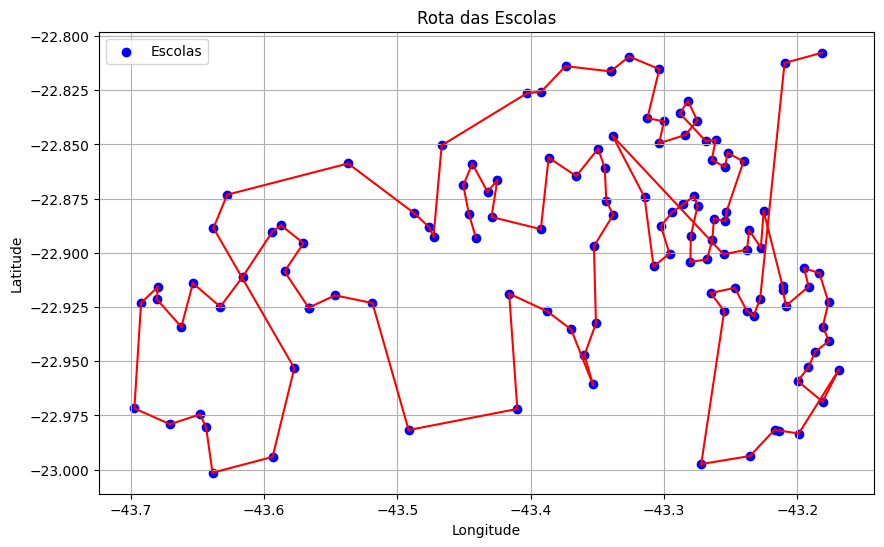

In [55]:
# Extrair as coordenadas de latitude e longitude
latitude = df_final['latitude']
longitude = df_final['longitude']

# Criar um gráfico de dispersão
plt.figure(figsize=(10, 6), facecolor='white')
plt.scatter(longitude, latitude, label='Escolas', color='blue')

# Adicionar uma linha vermelha que conecta os pontos na ordem do DataFrame
for i in range(len(latitude) - 1):
    plt.plot([longitude[i], longitude[i + 1]], [latitude[i], latitude[i + 1]], color='red')



# Configurações do gráfico
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rota das Escolas')
plt.legend()

# Salvar o gráfico como um arquivo PNG
plt.grid(True)
plt.savefig('rota_escolas.png', bbox_inches='tight', pad_inches=0.1)  # Ajuste de margem

# Exibir o gráfico
plt.show()


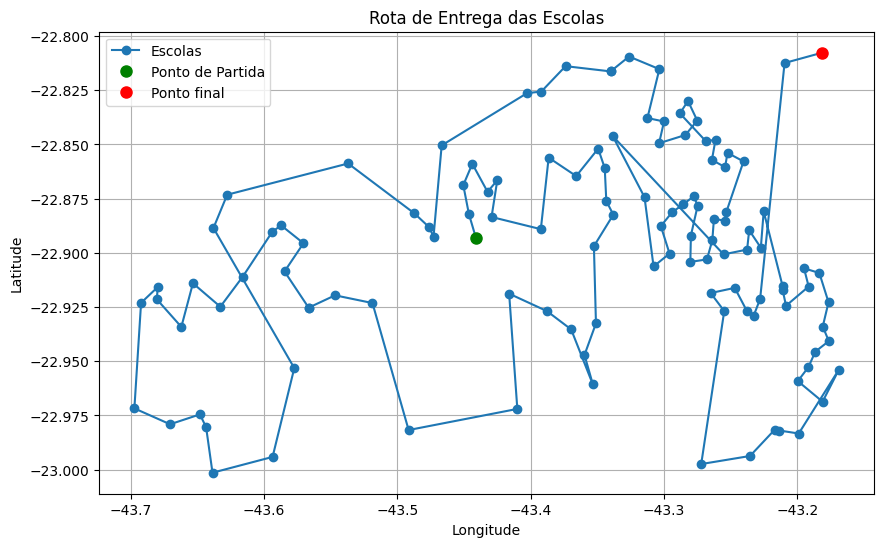

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(df_final['longitude'], df_final['latitude'], marker='o', label='Escolas', linestyle='-')
plt.plot(df_final['longitude'][0], df_final['latitude'][0], marker='o', markersize=8, label='Ponto de Partida', linestyle='None', color='green')
plt.plot(df_final['longitude'][119], df_final['latitude'][119], marker='o', markersize=8, label='Ponto final', linestyle='None', color='red')
plt.title('Rota de Entrega das Escolas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()